In [1]:
import os

import pandas as pd

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import  XGBRegressor

In [2]:
df = pd.read_csv('../../../data/merged_v4.csv')

In [3]:
print(df.columns)
print('total data:', len(df))

Index(['longitude', 'latitude', 'Area', 'Soil group', 'Land class',
       'Soil type', 'pH', 'SOC', 'Nitrogen', 'Potassium', 'Phosphorus',
       'Sulfur', 'Boron', 'Zinc', 'Sand', 'Silt', 'Clay'],
      dtype='object')
total data: 2438


In [4]:
df = df.drop(['SOC', 'Zinc', 'longitude', 'latitude'], axis=1)

<Axes: ylabel='Frequency'>

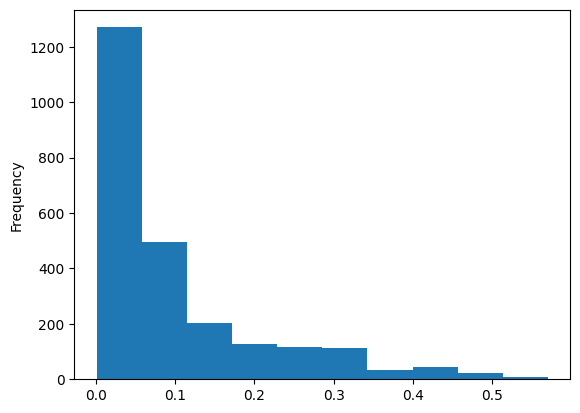

In [5]:
df['Boron'].plot(kind='hist')

In [6]:
## drop outlier of Boron
df = df[df['Boron'] <= 5]

print('total data:', len(df))

total data: 2438


In [7]:
print(df.groupby('Area').size())

Area
Adamawa             5
Bauchi            224
Gangachara          8
Kaduna            399
Kano               73
Katsina            81
Kaunia upazila     40
Kebbi              45
Kwara               5
Mithpukur         151
Nasarawa          213
Niger             553
Pirgacha           95
Plateau           352
Taraba            134
Taraganj Thana     60
dtype: int64


In [8]:
num_cols = ['pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']
cat_cols = ['Area', 'Soil group', 'Land class', 'Soil type']

In [9]:
labels = df['Boron']
features = df.drop('Boron', axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

In [10]:
num_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

col_transformer = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ],
        remainder= 'passthrough'
    )

In [11]:
col_transformer.fit(x_train)

train_data = col_transformer.transform(x_train).toarray()
test_data = col_transformer.transform(x_test).toarray()

In [12]:
alpha = [1, 5, 10]
solver = ['sparse_cg']
l1_ratio = [0.3, 0.5, 0.7, 1.0]
max_iter = [100, 500, 1000]
n_estimator = [100,300,500]
learning_rate = [0.1, 0.5, 1.0, 5.0]
loss_func = ['linear', 'square']
min_samples_split = [2, 3, 5, 7]
min_samples_leaf = [1, 3, 5, 7]

search_params = {
    'ridge': {
        'alpha': alpha,
        'max_iter': max_iter
    },
    'lasso': {
        'alpha': alpha,
        'max_iter': max_iter
    },
    'elasticNet': {
        'alpha': alpha,
        'max_iter': max_iter,
        'l1_ratio': l1_ratio
    },
    'adaboost': {
        'n_estimators': n_estimator,
        'learning_rate': learning_rate,
        'loss': loss_func
    },
    'bagging': {
        'n_estimators': n_estimator
    },
    'rf': {
        'n_estimators': n_estimator,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
    },
    'xgb': {
        'n_estimators': n_estimator,
        'learning_rate': learning_rate
    }
}

models = {
    'ridge': Ridge(random_state=0), 
    'lasso': Lasso(random_state=0), 
    'elasticNet': ElasticNet(random_state=0), 
    'adaboost': AdaBoostRegressor(random_state=0), 
    'bagging': BaggingRegressor(random_state=0), 
    'rf': RandomForestRegressor(random_state=0), 
    'xgb': XGBRegressor(random_state=0)
}

model_list = list(models.keys())

In [13]:
for model_name in model_list:
    model = models[model_name]
    params = search_params[model_name]

    print('fitting model', model_name)

    gs = GridSearchCV(
        model,
        param_grid=params,
        scoring='neg_root_mean_squared_error',
        n_jobs=1,
        cv=10,
        verbose = True
    )

    gs.fit(train_data, y_train)

    print(gs.best_estimator_)
    print(gs.best_params_)

    pred = gs.predict(test_data)

    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)

    print('R2:', round(r2,2))
    print('MAE:', round(mae,2))
    print('MSE:', round(mse,2))

    print('-'*30)

fitting model ridge
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Ridge(alpha=10, max_iter=100, random_state=0)
{'alpha': 10, 'max_iter': 100}
R2: 0.71
MAE: 0.04
MSE: 0.0
------------------------------
fitting model lasso
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Lasso(alpha=1, max_iter=100, random_state=0)
{'alpha': 1, 'max_iter': 100}
R2: -0.0
MAE: 0.08
MSE: 0.01
------------------------------
fitting model elasticNet
Fitting 10 folds for each of 36 candidates, totalling 360 fits
ElasticNet(alpha=1, l1_ratio=0.3, max_iter=100, random_state=0)
{'alpha': 1, 'l1_ratio': 0.3, 'max_iter': 100}
R2: -0.0
MAE: 0.08
MSE: 0.01
------------------------------
fitting model adaboost
Fitting 10 folds for each of 24 candidates, totalling 240 fits
AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=0)
{'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 100}
R2: 0.66
MAE: 0.05
MSE: 0.0
------------------------------
fitting model bagging
Fitting 

c:\Users\admin\miniconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'